In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import meshio

import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import re
import os

In [2]:
output_file = 'Quad9.msh'

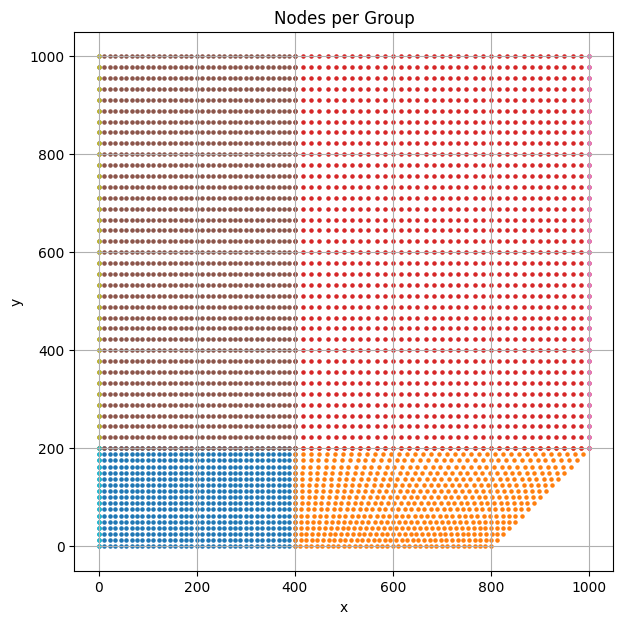

In [3]:
import meshio
import numpy as np
from collections import defaultdict
from nodes import Node  # Asegúrate que Node tenga `.index`, `.coord`, `.restrain` y `plot_nodes_por_grupo`

def make_nodes_groups_quad9(output_file, title):
    mesh = meshio.read(output_file)
    
    tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}
    grupos = defaultdict(dict)  # nombre_grupo: {id_nodo: Node}

    # Procesar elementos tipo quad9
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "quad9":
            continue
        for quad, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, str(tag))
            for node_id in quad:
                x, y = mesh.points[node_id][:2]
                if node_id not in grupos[nombre]:
                    grupos[nombre][node_id] = Node(node_id + 1, [x, y])

    # Procesar líneas tipo line3 para condiciones de borde
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "line3":
            continue
        for line, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, str(tag))
            for node_id in line:
                x, y = mesh.points[node_id][:2]
                restrain = [0, 0]
                if nombre == "Restriccion":
                    restrain = [1, 0]
                if np.isclose(x, 1000) and np.isclose(y, 1000):
                    restrain = [1, 1]
                if node_id not in grupos[nombre]:
                    grupos[nombre][node_id] = Node(node_id + 1, [x, y], restrain=restrain)
                else:
                    grupos[nombre][node_id].restrain = restrain  # Actualiza si ya existe

    # Convertir a listas
    grupos_final = {nombre: list(nodos.values()) for nombre, nodos in grupos.items()}

    # Visualizar (si está disponible)
    Node.plot_nodes_por_grupo(grupos_final, title, show_ids=False, save=False)

    return grupos_final, mesh

grupos, mesh = make_nodes_groups_quad9(output_file, "Quad9")

In [4]:
from material import Material

class Membrane:
    def __init__(self, thickness, material):
        self.thickness = thickness
        self.material = material

def make_sections(grupos):
    thickness_dict = {"1": 100, "2": 100, "3": 100, "4": 100}
    sections = {}

    for group in thickness_dict:
        material = Material(E=200e3, nu=0.36, gamma=7800e-9)
        sections[group] = Membrane(thickness_dict[group], material)

    nodes_dict = {}
    for group in grupos:
        for node in grupos[group]:
            nodes_dict[node.index] = node

    return sections, nodes_dict

sections, nodes_dict = make_sections(grupos)


In [5]:
# Extrae el primer elemento tipo quad9
nodes_mesh = mesh.cells_dict['quad9'][0]

print("Nodos del primer Quad9:")
for i, node_id in enumerate(nodes_mesh):
    global_id = node_id + 1  # Node usa índices base 1
    coord = nodes_dict[global_id].coord
    print(f"  Nodo local {i}: ID global {global_id}, coordenadas = {coord}")


Nodos del primer Quad9:
  Nodo local 0: ID global 1, coordenadas = [np.float64(0.0), np.float64(0.0)]
  Nodo local 1: ID global 18, coordenadas = [np.float64(22.22222222222222), np.float64(0.0)]
  Nodo local 2: ID global 396, coordenadas = [np.float64(22.22222222222223), np.float64(25.0)]
  Nodo local 3: ID global 241, coordenadas = [np.float64(0.0), np.float64(25.0)]
  Nodo local 4: ID global 27, coordenadas = [np.float64(11.11111111111111), np.float64(0.0)]
  Nodo local 5: ID global 489, coordenadas = [np.float64(22.22222222222223), np.float64(12.5)]
  Nodo local 6: ID global 490, coordenadas = [np.float64(11.11111111111111), np.float64(25.0)]
  Nodo local 7: ID global 249, coordenadas = [np.float64(0.0), np.float64(12.5)]
  Nodo local 8: ID global 491, coordenadas = [np.float64(11.11111111111111), np.float64(12.5)]


In [6]:
from Quad2D import Quad9

def make_quad9_elements(mesh, sections, nodes_dict):
    quads = mesh.cells_dict.get('quad9', [])
    tags = mesh.cell_data_dict["gmsh:physical"].get("quad9", [])
    elements = []
    used_nodes = set()
    nodos_faltantes = []
    errores_jacobiano = []

    for i in range(len(tags)):
        section_tag = str(tags[i])
        if section_tag not in sections:
            print(f"⚠️ Tag físico {section_tag} no tiene sección asociada. Elemento {i + 1} omitido.")
            continue

        section = sections[section_tag]
        node_ids = quads[i]

        try:
            nodos = [nodes_dict[node_id + 1] for node_id in node_ids]
        except KeyError as e:
            nodos_faltantes.append(node_ids)
            print(f"❌ Nodo no encontrado en nodes_dict: {e}")
            continue

        for nodo in nodos:
            used_nodes.add(nodo)

        # Intentamos crear el elemento y capturamos errores de Jacobiano
        try:
            element = Quad9(i + 1, nodos, section)
            elements.append(element)
        except ValueError as ve:
            print(f"❌ Error en el elemento {i + 1} con Jacobiano no positivo:")
            print(f"   Nodos: {[n.index for n in nodos]}")
            print(f"   Coordenadas:")
            for j, n in enumerate(nodos):
                print(f"     Nodo local {j}: ID {n.index}, coord = {n.coord}")
            errores_jacobiano.append(i + 1)
            continue

    if nodos_faltantes:
        print(f"❌ Se omitieron {len(nodos_faltantes)} elementos por nodos faltantes.")
    if errores_jacobiano:
        print(f"⚠️ Se omitieron {len(errores_jacobiano)} elementos por Jacobiano negativo.")

    return elements, list(used_nodes)


# Uso:
elements, used_nodes = make_quad9_elements(mesh, sections, nodes_dict)


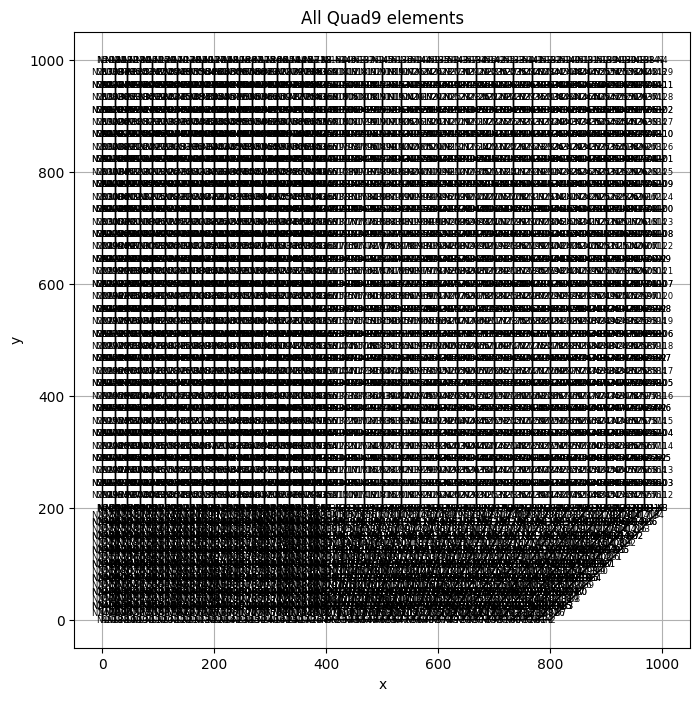

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_elements_quad9(elements, title, show_ids=True):
    all_x = []
    all_y = []

    for elem in elements:
        coords = elem.xy  # coords.shape = (9, 2)
        
        # Solo usar nodos de esquina para el contorno (0, 1, 2, 3, 0)
        border_nodes = [0, 1, 2, 3, 0]
        coords_border = np.array([coords[i] for i in border_nodes])
        
        all_x.extend(coords_border[:, 0])
        all_y.extend(coords_border[:, 1])

    # Márgenes y dimensiones
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.05

    x_range = (x_max - x_min) + 2 * x_margin
    y_range = (y_max - y_min) + 2 * y_margin

    fixed_width = 8
    height = fixed_width * (y_range / x_range)

    fig, ax = plt.subplots(figsize=(fixed_width, height))

    for elem in elements:
        coords = elem.xy  # coords.shape = (9, 2)
        
        # Dibujar contorno con nodos de esquina
        border_nodes = [0, 1, 2, 3, 0]
        coords_border = np.array([coords[i] for i in border_nodes])
        ax.plot(coords_border[:, 0], coords_border[:, 1], 'k-', linewidth=1)

        if show_ids:
            for nodo, (x, y) in zip(elem.node_list, coords):
                ax.text(x, y, f'N{nodo.index}', color='black', fontsize=6, ha='center', va='center')

    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True)

    plt.show()

# Uso:
plot_all_elements_quad9(elements, "All Quad9 elements", show_ids=True)


In [8]:
from solve import Solve

estructure = Solve(used_nodes, elements)



In [9]:
def apply_distributed_force(grupo_nodos, fuerza_total_y, estructura):
    """
    Aplica una fuerza distribuida vertical (por ejemplo, peso) sobre una línea formada por nodos.
    La fuerza se reparte proporcionalmente a la longitud de los tramos y se descompone en x e y.
    """

    nodos = grupo_nodos
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 1: calcular longitud total
    longitudes = []
    total_length = 0
    for i in range(n - 1):
        dx = nodos[i+1].coord[0] - nodos[i].coord[0]
        dy = nodos[i+1].coord[1] - nodos[i].coord[1]
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    q_lineal = fuerza_total_y / total_length  # fuerza por metro

    # Paso 2: inicializar diccionario de fuerzas
    nodal_forces = {node.index: np.array([0.0, 0.0]) for node in nodos}

    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coord
        xj, yj = nj.coord

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Vector perpendicular hacia "abajo"
        vx = dx / L
        vy = dy / L
        nx = -vy
        ny = vx

        Fi = q_lineal * L
        fx = Fi * nx
        fy = Fi * ny

        nodal_forces[ni.index] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.index] += np.array([fx / 2, fy / 2])

    # Paso 3: aplicar fuerzas al sistema
    for node in nodos:
        fx, fy = nodal_forces[node.index]
        dof_x, dof_y = node.dofs
        #estructura.apply_force(dof_x, fx)
        estructura.apply_force(dof_x, fx)
        print(f"Nodo {node.index} ← Fx = {fx:.3f} N, Fy = {fy:.3f} N")


nodos_fuerza = grupos["Fuerza_Y_1"]
apply_distributed_force(nodos_fuerza, fuerza_total_y=-1000, estructura=estructure)

nodos_fuerza = grupos["Fuerza_Y_2"]
apply_distributed_force(nodos_fuerza, fuerza_total_y=-1000, estructura=estructure)

Nodo 5 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 208 ← Fx = -7.042 N, Fy = 0.000 N
Nodo 217 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 200 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 218 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 209 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 219 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 201 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 220 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 210 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 221 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 202 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 222 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 211 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 223 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 203 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 224 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 212 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 225 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 204 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 226 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 213 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 227 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 205 ← Fx = -14.085 N, Fy = 0.000 N
Nodo 228 ← Fx = -14.085 N, Fy = 0.000 N
Nod

In [10]:
desplazamientos = estructure.solve()

🔧 Ensamblando matriz global...
DOFs used: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), 

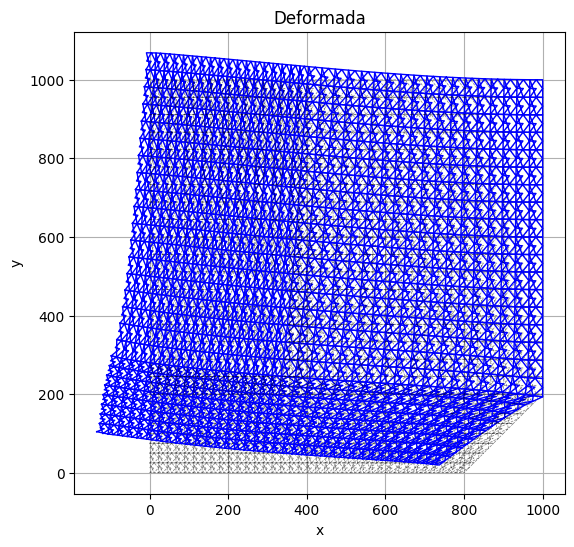

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_deformed_structure(elements, u_global, scale=1.0, show_original=True, title="Deformada"):
    """
    Grafica la estructura deformada a partir de los elementos y desplazamientos globales.
    
    Args:
        elements (list): Lista de elementos (Quad2D).
        u_global (ndarray): Vector global de desplazamientos (del solver).
        scale (float): Factor de escala para amplificar la deformación visualmente.
        show_original (bool): Si True, también grafica la geometría original.
        title (str): Título del gráfico.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect('equal')
    
    for elem in elements:
        # Coordenadas originales
        xy = elem.xy
        coords = np.vstack([xy, xy[0]])  # cerrar polígono

        if show_original:
            ax.plot(coords[:, 0], coords[:, 1], 'k--', linewidth=0.5, alpha=0.5)

        # Coordenadas deformadas
        idx = elem.calculate_indices()
        u_elem = u_global[idx].flatten()

        xy_def = xy + scale * u_elem.reshape(-1, 2)
        coords_def = np.vstack([xy_def, xy_def[0]])

        ax.plot(coords_def[:, 0], coords_def[:, 1], 'b-', linewidth=1)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True)
    plt.show()


plot_deformed_structure(elements, desplazamientos, scale=1000000.0, show_original=True, title="Deformada")

⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento con 9 nodos no soportado.
⚠️ Elemento 

ValueError: triangles must be a (N, 3) int array, but found shape (0,)

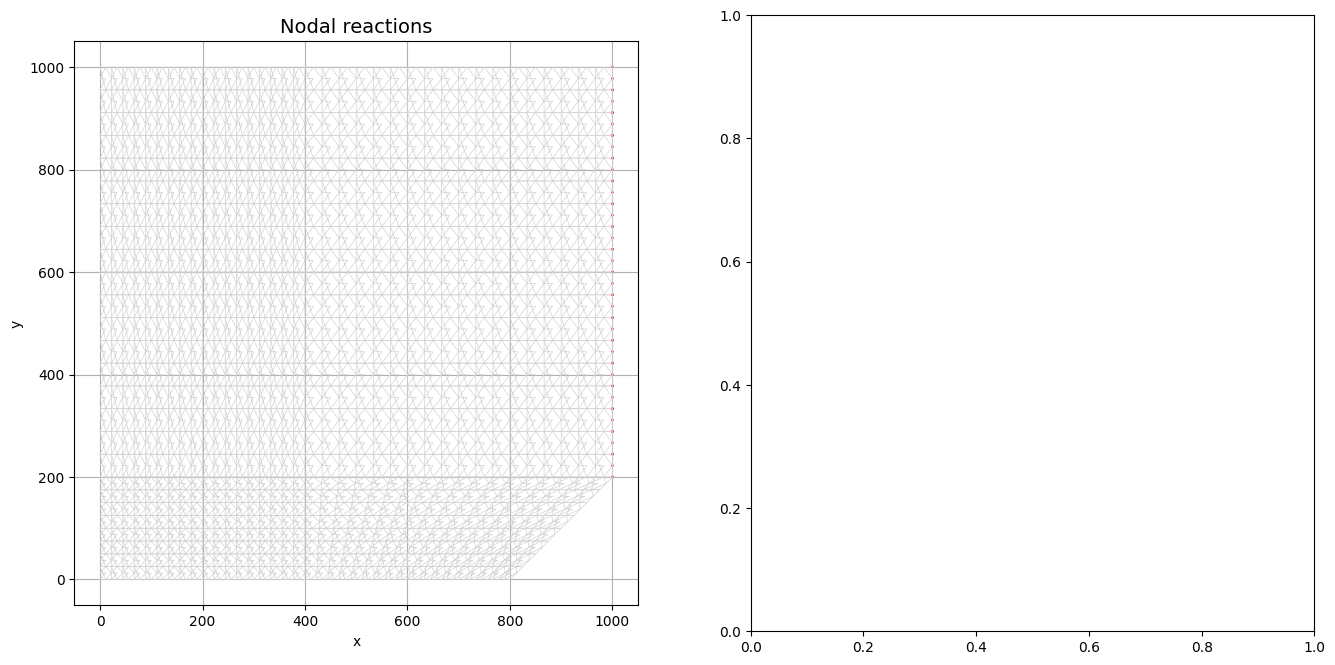

In [12]:
from graph import plot_results
plot_results(
    estructure,
    elements,
    title="mi_estructura",
    def_scale=500000,
    force_scale=1,
    reaction_scale=1e-2,
    sigma_y_tension=250, 
    sigma_y_compression=250
)

In [ ]:
for node in used_nodes:
    if node.coord[0] == 1000 and node.coord[1] <= 100:
        dof_y = node.dofs[1]  # Segundo DOF (desplazamiento vertical)
        uy = node.structure.u_global[dof_y, 0]
        print(f'📌 El desplazamiento vertical del nodo ({node.index}) es: {uy:.6f} mm')
